# Bayesian Optimisation with Scikit-Optimize

In this notebook, we will use **Bayesian Optimization** to select the best **hyperparameters** for a Gradient Boosting Regressor, using the open source Python package Scikit-Optimize.

Scikit-Optimize offers an interface that allows us to do the Optimization in a similar way to the GridSearchCV or RandomizedSearchCV from Scikit-learn, through the class BayesSearchCV

In this notebook, we will see how to do so.

#### Important
Remember that we use **Bayesian Optimization** when we are looking to optimize functions that are costly, like those derived from neuronal networks. For a Gradient Boosting Machine trained on little data like the one in this notebook, we would probably make a better search if we carried out a Random Search.

#### Hyperparameter Tunning Procedure
To tune the hyper-parameters of our model we need to:

* define a model
* decide which parameters to optimize
* define the objective function we want to minimize.

#### NOTE
Scikit-Optimize will always minimize the objective function, so if we want to maximize a function, for example the roc-auc, we need to negate the metric. Thus, instead of maximizing the roc-auc, we minimize the -roc-auc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# note that we only need to import the wrapper
from skopt import BayesSearchCV

In [2]:
# load dataset
boston_X, boston_y = load_boston(return_X_y=True)
X = pd.DataFrame(boston_X)
y = pd.Series(boston_y)

X.head()

/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

  

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


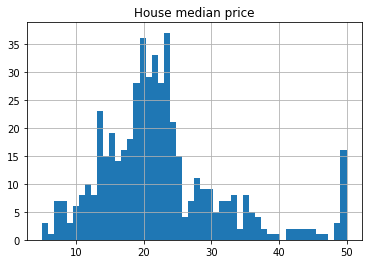

In [3]:
y.hist(bins=50)
plt.title("House median price")
plt.show()

In [4]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((354, 13), (152, 13))

## Define the model and Hyperparameter Space

In [5]:
# set up the model

gbm = GradientBoostingRegressor(random_state=0)

In [6]:
# hyperparameter space

param_grid = {
    'n_estimators': (10, 120), 
    'min_samples_split': (0.001, 0.99, 'log-uniform'),
    'max_depth': (1, 8),
    'loss': ['ls', 'lad', 'huber'],
}

In [7]:
# At the moment of creating this notebook, the BayesSearchCV is not
# compatible with sklearn version 0.24, because in this version the 
# param iid was deprecated from sklearn, and not yet from scikit-optimize

# make sure you have version 0.23 of sklearn to run this notebook
import sklearn
sklearn.__version__

'1.1.1'

## Bayesian Optimization

The rest of the notebook is very similar to that of RandomizedSearchCV, because the BayesSearchCV makes sure to bring forward all of Scikit-learn functionality.

In [8]:
# set up the search
search = BayesSearchCV(
    estimator=gbm,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=50,
    random_state=10,
    n_jobs=4,
    refit=True)

# find best hyperparameters
search.fit(X_train, y_train)

/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(
/home/santiago/anaconda3/envs/hyperparameter_optimization_for_machine_learning/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:301: FutureWarning: The

BayesSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=0),
              n_jobs=4, random_state=10, scoring='neg_mean_squared_error',
              search_spaces={'loss': ['ls', 'lad', 'huber'],
                             'max_depth': (1, 8),
                             'min_samples_split': (0.001, 0.99, 'log-uniform'),
                             'n_estimators': (10, 120)})

In [9]:
# the best hyperparameters are stored in an attribute

search.best_params_

OrderedDict([('loss', 'huber'),
             ('max_depth', 3),
             ('min_samples_split', 0.011493762380048851),
             ('n_estimators', 74)])

In [10]:
# the best score

search.best_score_

-11.555088456356303

In [11]:
# we also find the data for all models evaluated

results = pd.DataFrame(search.cv_results_)

print(results.shape)

results.head()

(50, 15)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.516908,0.018659,0.002581,0.000525,huber,3,0.044228,80,"{'loss': 'huber', 'max_depth': 3, 'min_samples...",-10.558287,-16.394026,-13.460963,-13.471092,2.382441,35
1,0.068624,0.009148,0.002404,0.000646,ls,2,0.308189,76,"{'loss': 'ls', 'max_depth': 2, 'min_samples_sp...",-11.740731,-18.260354,-14.708708,-14.903264,2.665178,44
2,0.166714,0.012566,0.002432,0.000627,lad,3,0.002288,48,"{'loss': 'lad', 'max_depth': 3, 'min_samples_s...",-9.253265,-17.728812,-18.140297,-15.040791,4.095845,45
3,0.127385,0.004397,0.004555,0.002957,ls,5,0.001897,90,"{'loss': 'ls', 'max_depth': 5, 'min_samples_sp...",-17.641456,-26.860518,-9.886990,-18.129655,6.938007,49
4,0.070725,0.002778,0.002181,0.000234,ls,4,0.054687,54,"{'loss': 'ls', 'max_depth': 4, 'min_samples_sp...",-11.734966,-26.734377,-11.014968,-16.494771,7.246459,48


Text(0.5, 0, 'Hyperparameter combinations')

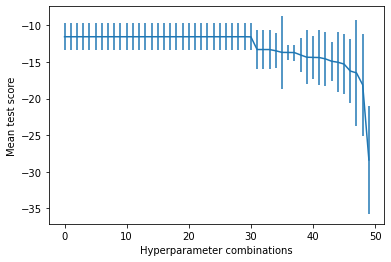

In [12]:
# we can order the different models based on their performance
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.reset_index(drop=True, inplace=True)

# plot model performance and error

results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [13]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train MSE: ', mean_squared_error(y_train, X_train_preds))
print('Test MSE: ', mean_squared_error(y_test, X_test_preds))

Train MSE:  2.077241345322855
Test MSE:  15.810352809406744
